# Set up

In [547]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [548]:
import os
os.getcwd()

'/content/drive/My Drive/Projects/2. House Prices Prediction'

In [549]:
%cd /content/drive/MyDrive/Projects/2. House Prices Prediction

/content/drive/MyDrive/Projects/2. House Prices Prediction


In [550]:
# plotting

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# processing

import re
import numpy as np
import pandas as pd
import copy
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr, spearmanr

# models

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

In [551]:
warnings.filterwarnings('ignore')

In [552]:
pio.templates.default = "plotly_dark"

# Importing datasets

In [553]:
TRAIN_CSV = "train.csv"
TEST_CSV =  "test.csv"
DESC_TXT = "data_description.txt"
SAMPLE_CSV = "sample_submission.csv"

In [554]:
df_train = pd.read_csv(TRAIN_CSV)
df_train.shape

(1460, 81)

In [555]:
df_test = pd.read_csv(TEST_CSV)
df_test.shape

(1459, 80)

In [556]:
with open(DESC_TXT, "r") as desc_txt:
  desc = desc_txt.read()

regex = re.compile(r"(\b.+):(.*)\n")
fields = dict(re.findall(regex, desc))

In [557]:
fields

{'MSSubClass': ' Identifies the type of dwelling involved in the sale.\t',
 'MSZoning': ' Identifies the general zoning classification of the sale.',
 'LotFrontage': ' Linear feet of street connected to property',
 'LotArea': ' Lot size in square feet',
 'Street': ' Type of road access to property',
 'Alley': ' Type of alley access to property',
 'LotShape': ' General shape of property',
 'LandContour': ' Flatness of the property',
 'Utilities': ' Type of utilities available',
 'LotConfig': ' Lot configuration',
 'LandSlope': ' Slope of property',
 'Neighborhood': ' Physical locations within Ames city limits',
 'Condition1': ' Proximity to various conditions',
 'Condition2': ' Proximity to various conditions (if more than one is present)',
 'BldgType': ' Type of dwelling',
 'HouseStyle': ' Style of dwelling',
 '1.5Fin\tOne and one-half story': ' 2nd level finished',
 '1.5Unf\tOne and one-half story': ' 2nd level unfinished',
 '2.5Fin\tTwo and one-half story': ' 2nd level finished',
 '2

In [558]:
# in the data_description.txt file, there is a feature Bedroom, but this feature is called BedroomAbvGrd in the dataset
# similarly, there is a feature Kitchen in the text file, but this feature is called KitchenAbvGrd in the dataset
# let's rename the dataset columns to match the data_description.txt file

df_train.rename(columns={"KitchenAbvGr": "Kitchen", "BedroomAbvGr": "Bedroom"}, inplace=True)
df_test.rename(columns={"KitchenAbvGr": "Kitchen", "BedroomAbvGr": "Bedroom"}, inplace=True)

# Cleaning datasets

In [559]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Dropping unnecessary columns

In [560]:
df_train.drop(columns=["Id"], inplace=True)

## Fixing null elements

In [561]:
df_train.isnull().sum().sum()

6965

In [562]:
df_test.isnull().sum().sum()

7000

In [563]:
# output for df_train.isnull().sum() is truncated
# using iteritems() to iterate through df_train null elements

for key, value in df_test.isnull().sum().iteritems():
  if value > 0:
    print(key, value)

MSZoning 4
LotFrontage 227
Alley 1352
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
BsmtQual 44
BsmtCond 45
BsmtExposure 44
BsmtFinType1 42
BsmtFinSF1 1
BsmtFinType2 42
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 730
GarageType 76
GarageYrBlt 78
GarageFinish 78
GarageCars 1
GarageArea 1
GarageQual 78
GarageCond 78
PoolQC 1456
Fence 1169
MiscFeature 1408
SaleType 1


In [564]:
# some columns use nan to represent 0

zero_imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)

cols = ["LotFrontage", "MasVnrArea", "BsmtFinSF1", "GarageYrBlt"]

df_train[cols] = zero_imputer.fit_transform(df_train[cols])
df_test[cols] = zero_imputer.fit_transform(df_test[cols])

In [565]:
# some categorical columns use nan to represent an absence of a particular feature
# for e.g. nan values found in the "Alley" column represent houses that do not have an alley way
# instead of using nan, we will use the string "Absent"

absent_imputer_nan = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="Absent")

cols = ["Alley", "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
        "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish",
        "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature",
        "Electrical"]

df_train[cols] = absent_imputer_nan.fit_transform(df_train[cols])
df_test[cols] = absent_imputer_nan.fit_transform(df_test[cols])

# same imputer, but missing_values=None

absent_imputer_none = SimpleImputer(missing_values="None", strategy="constant", fill_value="Absent")

cols = ["MasVnrType"]

df_train[cols] = absent_imputer_none.fit_transform(df_train[cols])
df_test[cols] = absent_imputer_none.fit_transform(df_test[cols])

In [566]:
# for other numerical columns, let use the average to impute the missing values

# note: we could also use a simple regression model to impute these values, but
# I decided to go for the simpler option

average_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")

cols = ["BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath",
        "GarageCars", "GarageArea"]

df_train[cols] = average_imputer.fit_transform(df_train[cols])
df_test[cols] = average_imputer.fit_transform(df_test[cols])

In [567]:
# for other categorial columns, we will use the most popular category from each column to impute the missing values

cols = ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "KitchenQual",
        "Functional", "SaleType"]

for col in cols:
  vc = df_train[col].value_counts()
  fill_value = vc.index[0]
  
  df_train[col].fillna(fill_value, inplace=True)
  df_test[col].fillna(fill_value, inplace=True)


In [568]:
df_train.isnull().sum().sum()

0

In [569]:
df_test.isnull().sum().sum()

0

In [570]:
df_train.shape

(1460, 80)

In [571]:
df_test.shape

(1459, 80)

## Fixing data types

In [572]:
for x, y in df_train.dtypes.iteritems():
  print(f"{x}: {y}")

MSSubClass: int64
MSZoning: object
LotFrontage: float64
LotArea: int64
Street: object
Alley: object
LotShape: object
LandContour: object
Utilities: object
LotConfig: object
LandSlope: object
Neighborhood: object
Condition1: object
Condition2: object
BldgType: object
HouseStyle: object
OverallQual: int64
OverallCond: int64
YearBuilt: int64
YearRemodAdd: int64
RoofStyle: object
RoofMatl: object
Exterior1st: object
Exterior2nd: object
MasVnrType: object
MasVnrArea: float64
ExterQual: object
ExterCond: object
Foundation: object
BsmtQual: object
BsmtCond: object
BsmtExposure: object
BsmtFinType1: object
BsmtFinSF1: float64
BsmtFinType2: object
BsmtFinSF2: float64
BsmtUnfSF: float64
TotalBsmtSF: float64
Heating: object
HeatingQC: object
CentralAir: object
Electrical: object
1stFlrSF: int64
2ndFlrSF: int64
LowQualFinSF: int64
GrLivArea: int64
BsmtFullBath: float64
BsmtHalfBath: float64
FullBath: int64
HalfBath: int64
Bedroom: int64
Kitchen: int64
KitchenQual: object
TotRmsAbvGrd: int64
Functi

In [573]:
# these cols are of type object but should be of type int
cols = ["BsmtFinSF1", "GarageYrBlt"]

for col in cols:
  df_train[col] = df_train[col].astype(np.int)
  df_test[col] = df_test[col].astype(np.int)

In [574]:
# MSSubClass is a categorical variable and should be of type string

df_train["MSSubClass"] = df_train["MSSubClass"].apply(lambda x: str(x))
df_test["MSSubClass"] = df_test["MSSubClass"].apply(lambda x: str(x))

## Removing outliers

In [575]:
def get_upper_fence(col):
  stats = df_train[col].describe()
  Q1 = stats["25%"]
  Q3 = stats["75%"]
  IQR = Q3 - Q1
  return Q3 + (1.5 * IQR)

In [576]:
px.box(df_train["LotArea"])

In [577]:
# average house size in iowa is 1550 square feet
# house sizes greater than 17000 square feet are definitely outliers due to errors in recording
# we need to remove these inaccurate values

df_train = df_train[df_train["LotArea"] < get_upper_fence("LotArea")]

In [578]:
# getting the most expensive house

most_exp = df_train.sort_values(by=["SalePrice"], ascending=False).iloc[0, :]
most_exp

MSSubClass            60
MSZoning              RL
LotFrontage        160.0
LotArea            15623
Street              Pave
                  ...   
MoSold                 7
YrSold              2007
SaleType              WD
SaleCondition    Abnorml
SalePrice         745000
Name: 1182, Length: 80, dtype: object

## Saving test dataset ID column

In [579]:
# we will need the Id column of the test dataset later for prediction purposes

test_id = df_test.pop("Id")

# EDA

## Data Distributions Summary

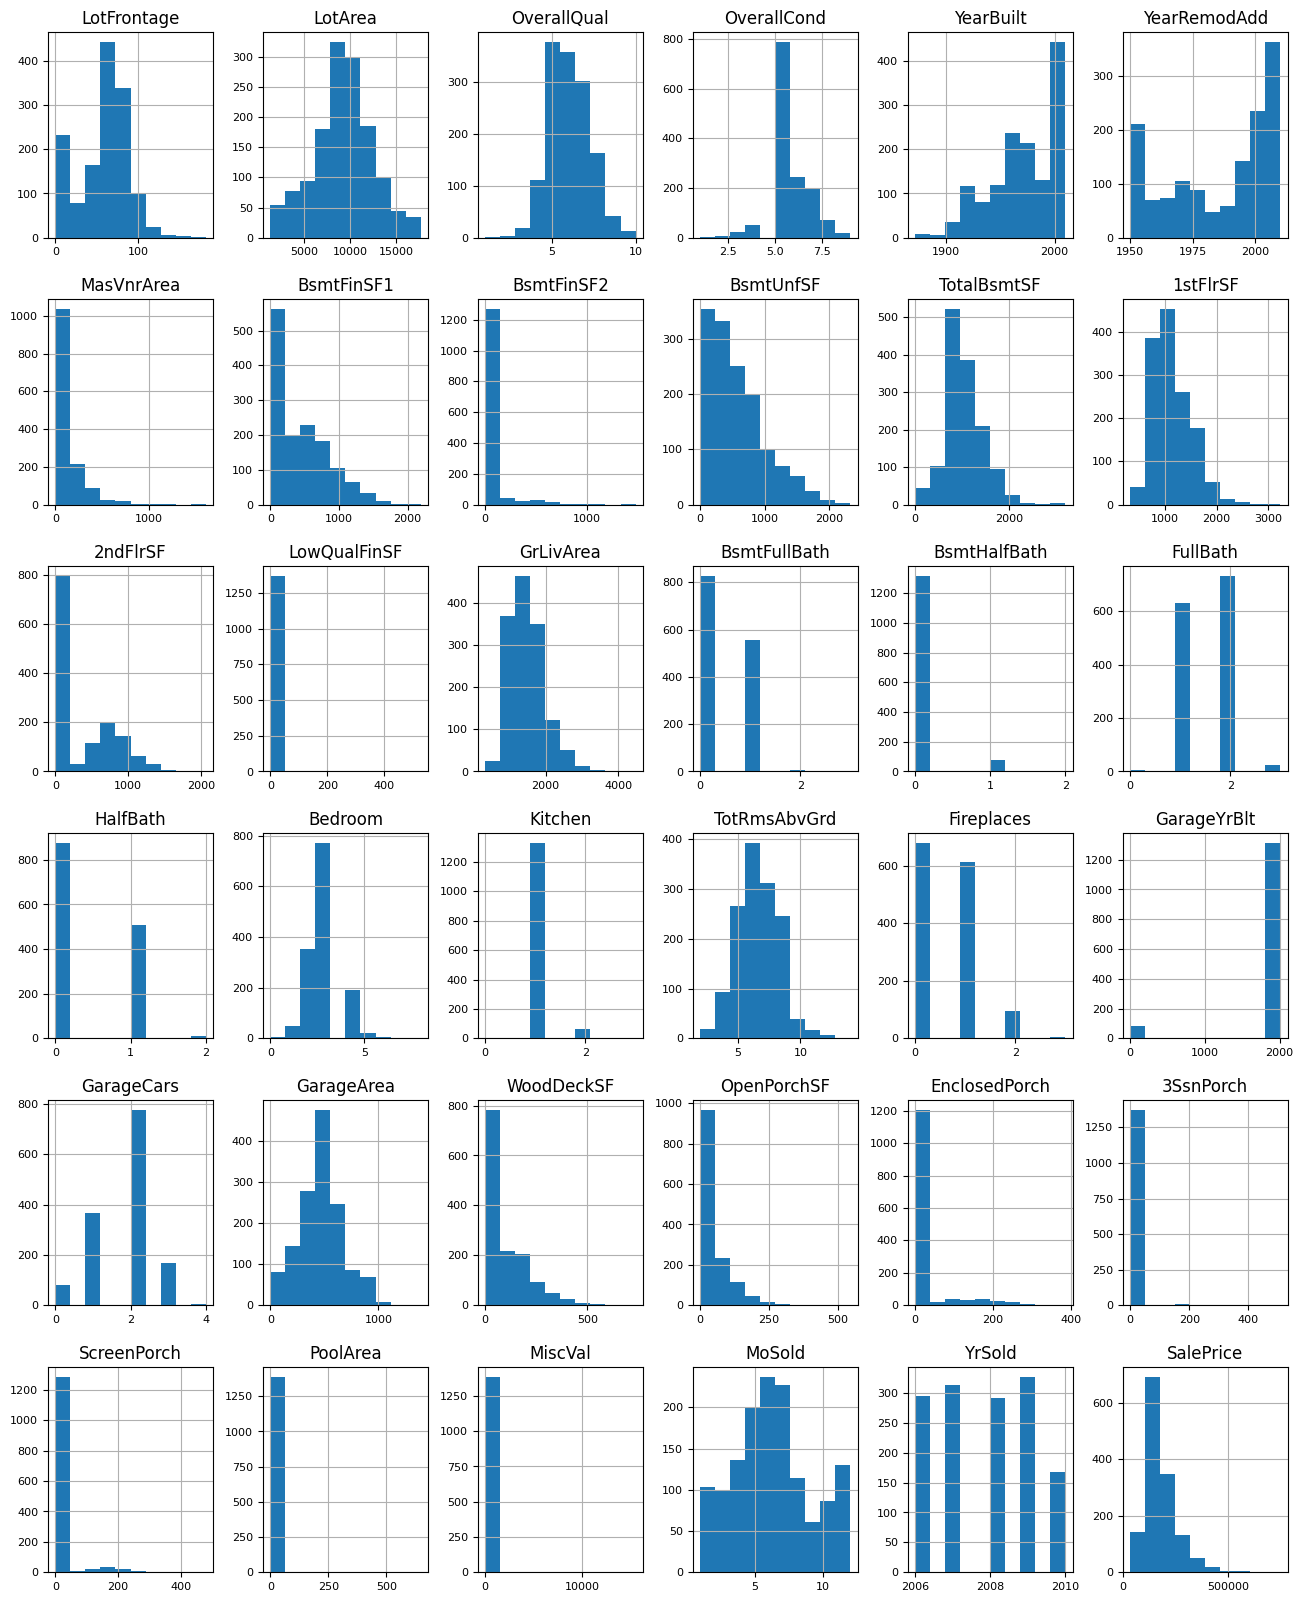

In [580]:
df_train.hist(figsize=(16, 20), xlabelsize=8, ylabelsize=8)
plt.show()

## SalePrice Correlation Bar Graph

In [581]:
# correlation of features to saleprice

salesprice_corr = df_train.corr()["SalePrice"].sort_values(ascending=False)
fig = px.bar(
    x=salesprice_corr.index,
    y=salesprice_corr.values,
    color=salesprice_corr.values,
    title="Correlation to SalePrice",
    labels={
        "x": "Features",
        "y": "Pearson Correlation to SalePrice"
    },
)
fig.update_layout(coloraxis_showscale=False)

Highly correlated features:
- **OverallQual** (Rates the overall material and finish of the house)
- **GrLivArea** (Above grade (ground) living area square feet)
- **TotalBsmtSF** (Total square feet of basement area)
- **GarageCars** (Size of garage in car capacity)
- **GarageArea** (Size of garage in square feet)
- **1stFlrSF** (First Floor square feet)
- **FullBath** (Full bathrooms above grade)

Let's graph scatter plots for these features based on their relationship to SalePrice:

## Scatter: SalesPrice X OverallQual

In [582]:
px.scatter(
    df_train, 
    x="OverallQual", 
    y="SalePrice",
    trendline="ols", # ordinary least squares regression line
    title="SalePrice by OverallQual (Rates the overall material and finish of the house)"
)

## Scatter: SalesPrice X GrLivArea

In [583]:
px.scatter(
    df_train, 
    x="GrLivArea", 
    y="SalePrice",
    trendline="ols",
    title="SalePrice by GrLivArea (Above grade living area square feet)",
    color_discrete_sequence=px.colors.cmocean.algae
)

## Scatter: SalesPrice X TotalBsmtSF

In [584]:
px.scatter(
    df_train, 
    x="TotalBsmtSF", 
    y="SalePrice",
    trendline="ols",
    title="SalePrice by TotalBsmtSF (Total square feet of basement area)",
    color_discrete_sequence=["#90ee90"],
)

## Scatter: SalesPrice X GarageArea

In [585]:
px.scatter(
    df_train, 
    x="GarageArea", 
    y="SalePrice",
    trendline="ols",
    title="SalePrice by GarageArea (Size of garage in square feet)",
    color_discrete_sequence=["orange"]
)

## Scatter: SalesPrice X 1stFlrSF

In [586]:
px.scatter(
    df_train, 
    x="1stFlrSF", 
    y="SalePrice",
    trendline="ols",
    title="SalePrice by 1stFlrSF (First Floor square feet)",
    color_discrete_sequence=["#8F00FF"]
)

## Correlations between features

In [587]:
def get_top_n_correlated_features(dataset, n, method="pearson", reverse=False):

  # getting correlations between all variables
  corrs = []
  for key1, arr in dataset.corr(method=method).iteritems():
    for key2, corr in arr.iteritems():
      corrs.append((key1, key2, corr))

  # sorting by abs(correlation)
  corrs.sort(key=lambda x: abs(x[2]), reverse=True)

  # removing every second correlation as they are duplicates
  corrs = corrs[::2]

  # removing elements that are correlated to themselves (corr=1)

  if reverse:
    # return the botton n correlations
    return corrs[-n:]

  # returning the top n correlations
  return corrs[:n]

In [588]:
corrs = get_top_n_correlated_features(df_train, 5)
corrs

[('GarageCars', 'GarageArea', 0.8892790802725081),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8305307356416959),
 ('TotalBsmtSF', '1stFlrSF', 0.8097217580849593),
 ('OverallQual', 'SalePrice', 0.8071976257698699),
 ('GrLivArea', 'SalePrice', 0.7238841241334821)]

In [589]:
colors = ["#04e762", "#f5b700", "#dc0073", "#008bf8", "#89fc00"]
for i in range(5):
  corr_arr = corrs[i]
  scatter = px.scatter(
    df_train, 
    x=corr_arr[0], 
    y=corr_arr[1],
    trendline="ols",
    title=f"{corr_arr[0]} by {corr_arr[1]}",
    color_discrete_sequence=[colors[i]]
  )
  scatter.show()

# Feature engineering

## In depth feature analysis + feature engineering/selection

I have organised the features into the following groups:
- **General**: general information about the property
- **Property Surroundings/Environment**: features that do not pertain to the property itself (such as which neighbourhood the property is in)
- **Property Exterior/Structure**: information about the structure of the property
- **Porch**
- **Property Interior**
- **Ratings**
- **Dates**
- **Basement**
- **Utilities**
- **Rooms**
- **Garage**

In [590]:
sorted_cols = {
    "General": [
        "MSSubClass",
        "MSZoning",
        "BldgType",
        "HouseStyle",
        "Functional",
        "MiscFeature",
        "MiscVal",
        "SaleType",
        "SaleCondition",
    ],
    "Property Surroundings/Environment": [
        "LotFrontage",
        "Street",
        "Alley",
        "Neighborhood",
        "Condition1",
        "Condition2",
        "PavedDrive",
    ],
    "Property Exterior/Structure": [
        "LotArea",
        "LotShape",
        "LandContour",
        "LotConfig",
        "LandSlope",
        "RoofStyle",
        "RoofMatl",
        "Exterior1st",
        "Exterior2nd",
        "MasVnrType",
        "MasVnrArea",
        "Foundation",
        "WoodDeckSF",
    ],
    "Porch": [
        "OpenPorchSF",
        "EnclosedPorch",
        "3SsnPorch",
        "ScreenPorch",
    ],
    "Property Interior": [
        "1stFlrSF",
        "2ndFlrSF",
        "LowQualFinSF",
        "GrLivArea",
        "Fireplaces",
        "PoolArea",
    ],
    "Ratings": [
        "OverallQual",
        "OverallCond",
        "ExterQual",
        "ExterCond",
        "HeatingQC",
        "KitchenQual",
        "FireplaceQu",
        "PoolQC",
        "Fence",
        "BsmtQual",
        "BsmtCond",
        "GarageQual",
        "GarageCond",
    ],
    "Dates": [
        "YearBuilt",
        "YearRemodAdd",
        "MoSold",
        "YrSold",
    ],
    "Basement": [
        "BsmtExposure",
        "BsmtFinType1",
        "BsmtFinSF1",
        "BsmtFinType2",
        "BsmtFinSF2",
        "BsmtUnfSF",
        "TotalBsmtSF",
    ],
    "Utilities": [
        "Utilities",
        "Heating",
        "CentralAir",
        "Electrical",
    ],
    "Rooms": [
        "BsmtFullBath",
        "BsmtHalfBath",
        "FullBath",
        "HalfBath",
        "Bedroom",
        "Kitchen",
        "TotRmsAbvGrd",
    ],
    "Garage": [
        "GarageType",
        "GarageYrBlt",
        "GarageFinish",
        "GarageCars",
        "GarageArea",
    ]
}

Helper functions:

In [591]:
"""
Plots a bar graph based on the value counts (intended use for categorical variables).
If pie=True, a pie chart based on the value counts will also be graphed.
"""

def graph_counts(dataset, col, pie=False):
  vc = dataset[col].value_counts()
  bar = px.bar(x=vc.index.astype(str), y=vc.values, title=col, labels={"x": col, "y": "Counts"})
  bar.show()

  if pie:
    piec = px.pie(names=vc.index.astype(str), values=vc.values)
    piec.update_traces(textposition='inside', textinfo='percent+label')
    piec.show()

In [592]:
"""
Replaces values 'to_be_replaced' with 'replacement' in column 'col'
"""

def replace_values(dataset, col, to_be_replaced, replacement):
  dataset.loc[dataset[col].isin(to_be_replaced), col] = replacement

In [593]:
"""
For categorical column 'col', this function returns all the values in 'col' that
appear less than 'thresh' times in 'col'
"""

def get_replacement_values(dataset, col, thresh):
  replace_vals = []
  vc = dataset[col].value_counts()
  for cat in vc.index:
    if len(dataset[dataset[col]==cat]) <= thresh:
      replace_vals.append(cat)

  return replace_vals

In [594]:
"""
Prints the Pearson and Spearman correlation between 2 columns in a dataset
"""

def print_numerical_corr(dataset, col1, col2):
  pr = pearsonr(dataset[col1], dataset[col2]).statistic
  sr = spearmanr(dataset[col1], dataset[col2]).statistic

  print(f"Pearson correlation of {col1} to {col2}: {pr}")
  print(f"Spearman correlation of {col1} to {col2}: {sr}")

### General

In [595]:
sorted_cols["General"]

['MSSubClass',
 'MSZoning',
 'BldgType',
 'HouseStyle',
 'Functional',
 'MiscFeature',
 'MiscVal',
 'SaleType',
 'SaleCondition']

MSSubClass

In [596]:
graph_counts(df_train, "MSSubClass")

In [597]:
replace_values(
    dataset=df_train, 
    col="MSSubClass", 
    to_be_replaced=["70", "80", "90", "190", "85", "75", "45", "180", "40", "150"], 
    replacement="Other"
)

replace_values(
    dataset=df_test, 
    col="MSSubClass", 
    to_be_replaced=["70", "80", "90", "190", "85", "75", "45", "180", "40", "150"], 
    replacement="Other"
)

In [598]:
graph_counts(df_train, "MSSubClass")

MSZoning

In [599]:
graph_counts(df_train, "MSZoning")

In [600]:
replace_values(
    dataset=df_train, 
    col="MSZoning", 
    to_be_replaced=["FV", "RH", "C (all)"], 
    replacement="Other"
)

replace_values(
    dataset=df_test, 
    col="MSZoning", 
    to_be_replaced=["FV", "RH", "C (all)"], 
    replacement="Other"
)

In [601]:
graph_counts(df_train, "MSZoning")

BldgType

In [602]:
graph_counts(df_train, "BldgType")

In [603]:
replace_values(
    dataset=df_train, 
    col="BldgType", 
    to_be_replaced=["Duplex", "Twnhs", "2fmCon"], 
    replacement="Other"
)

replace_values(
    dataset=df_test, 
    col="BldgType", 
    to_be_replaced=["Duplex", "Twnhs", "2fmCon"], 
    replacement="Other"
)

In [604]:
graph_counts(df_train, "BldgType")

HouseStyle

In [605]:
graph_counts(df_train, "HouseStyle")

In [606]:
replace_values(
    dataset=df_train, 
    col="HouseStyle", 
    to_be_replaced=["SFoyer", "1.5Unf", "2.5Unf", "2.5Fin"], 
    replacement="Other"
)

replace_values(
    dataset=df_test, 
    col="HouseStyle", 
    to_be_replaced=["SFoyer", "1.5Unf", "2.5Unf", "2.5Fin"], 
    replacement="Other"
)

In [607]:
graph_counts(df_train, "HouseStyle")

Functional

In [608]:
graph_counts(df_train, "Functional")

In [609]:
replace_values(
    dataset=df_train, 
    col="Functional", 
    to_be_replaced=["Min2", "Min1", "Mod", "Maj1", "Maj2", "Sev"], 
    replacement="Damaged"
)

replace_values(
    dataset=df_test, 
    col="Functional", 
    to_be_replaced=["Min2", "Min1", "Mod", "Maj1", "Maj2", "Sev"], 
    replacement="Damaged"
)

In [610]:
graph_counts(df_train, "Functional")

MiscFeature

In [611]:
graph_counts(df_train, "MiscFeature")

In [612]:
# most values in MiscFeature are "Absent" so we will drop it

df_train.drop(columns="MiscFeature", inplace=True)
df_test.drop(columns="MiscFeature", inplace=True)

MiscVal

In [613]:
px.histogram(df_train["MiscVal"])

In [614]:
print_numerical_corr(df_train, "MiscVal", "SalePrice")

Pearson correlation of MiscVal to SalePrice: -0.02419333899631744
Spearman correlation of MiscVal to SalePrice: -0.06649236428955341


In [615]:
# let's drop this feature as it has little correlation to SalePrice

df_train.drop(columns="MiscVal", inplace=True)
df_test.drop(columns="MiscVal", inplace=True)

SaleType

In [616]:
graph_counts(df_train, "SaleType")

In [617]:
replace_values(
    df_train, "SaleType", ["WD", "CWD", "VWD"], "Warranty Deed"
)

replace_values(
    df_train, "SaleType", ["Con", "ConLw", "ConLI", "ConLD"], "Contract"
)

replace_values(
    df_train, "SaleType", ["COD", "Oth"], "Other"
)

replace_values(
    df_test, "SaleType", ["WD", "CWD", "VWD"], "Warranty Deed"
)

replace_values(
    df_test, "SaleType", ["Con", "ConLw", "ConLI", "ConLD"], "Contract"
)

replace_values(
    df_test, "SaleType", ["COD", "Oth"], "Other"
)

In [618]:
graph_counts(df_train, "SaleType")

SaleCondition

In [619]:
graph_counts(df_train, "SaleCondition")

In [620]:
replace_values(
    df_train, "SaleCondition", ["Abnorml", "Family", "Alloca", "AdjLand"], "Other"
)

replace_values(
    df_test, "SaleCondition", ["Abnorml", "Family", "Alloca", "AdjLand"], "Other"
)

In [621]:
graph_counts(df_train, "SaleCondition")

### Property Surroundings/Environment

In [622]:
sorted_cols["Property Surroundings/Environment"]

['LotFrontage',
 'Street',
 'Alley',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'PavedDrive']

LotFrontage

In [623]:
px.histogram(df_train["LotFrontage"])

Street

In [624]:
graph_counts(df_train, "Street")

In [625]:
len(df_train[df_train["Street"]=="Grvl"])

3

In [626]:
len(df_test[df_test["Street"]=="Grvl"])

6

In [627]:
# there are extremely few instances of Street=Grvl
# since this only leaves one more category (Pave), we can essentially drop this column

df_train.drop(columns="Street", inplace=True)
df_test.drop(columns="Street", inplace=True)

Alley

In [628]:
graph_counts(df_train, "Alley")

In [629]:
replace_values(
    df_train, "Alley", ["Grvl", "Pave"], "Has Access"
)

replace_values(
    df_test, "Alley", ["Grvl", "Pave"], "Has Access"
)

In [630]:
graph_counts(df_train, "Alley")

Neighborhood

In [631]:
graph_counts(df_train, "Neighborhood")

In [632]:
replace_vals = get_replacement_values(df_train, "Neighborhood", 60)

print(replace_vals)

replace_values(
    df_train, "Neighborhood", replace_vals, "Other"
)

replace_values(
    df_test, "Neighborhood", replace_vals, "Other"
)

['SawyerW', 'BrkSide', 'Crawfor', 'Mitchel', 'NoRidge', 'IDOTRR', 'Timber', 'SWISU', 'StoneBr', 'MeadowV', 'Blmngtn', 'BrDale', 'ClearCr', 'Veenker', 'NPkVill', 'Blueste']


In [633]:
graph_counts(df_train, "Neighborhood")

Condition1

In [634]:
graph_counts(df_train, "Condition1")

In [635]:
replace_vals = get_replacement_values(df_train, "Condition1", 50)

print(replace_vals)

replace_values(
    df_train, "Condition1", replace_vals, "Other"
)

replace_values(
    df_test, "Condition1", replace_vals, "Other"
)

['Artery', 'RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe']


In [636]:
graph_counts(df_train, "Condition1")

Condition2

In [637]:
graph_counts(df_train, "Condition2")

In [638]:
# we can drop this column as the vast majority of values lie in one category

df_train.drop(columns="Condition2", inplace=True)
df_test.drop(columns="Condition2", inplace=True)

PavedDrive

In [639]:
graph_counts(df_train, "PavedDrive")

In [640]:
replace_values(
    df_train, "PavedDrive", ["N", "P"], "Partial/Dirt/Gravel"
)

replace_values(
    df_test, "PavedDrive", ["N", "P"], "Partial/Dirt/Gravel"
)

In [641]:
graph_counts(df_train, "PavedDrive")

### Property Exterior/Structure

In [642]:
sorted_cols["Property Exterior/Structure"]

['LotArea',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'Foundation',
 'WoodDeckSF']

LotArea

In [643]:
px.histogram(df_train["LotArea"])

LotShape

In [644]:
graph_counts(df_train, "LotShape")

In [645]:
replace_values(
    df_train, "LotShape", ["IR1", "IR2", "IR3"], "Irregular"
)

replace_values(
    df_test, "LotShape", ["IR1", "IR2", "IR3"], "Irregular"
)

In [646]:
graph_counts(df_train, "LotShape")

LandContour

In [647]:
graph_counts(df_train, "LandContour")

In [648]:
replace_values(
    df_train, "LandContour", ["HLS", "Low"], "Other"
)

replace_values(
    df_test, "LandContour", ["HLS", "Low"], "Other"
)

In [649]:
graph_counts(df_train, "LandContour")

LotConfig

In [650]:
graph_counts(df_train, "LotConfig")

In [651]:
replace_values(
    df_train, "LotConfig", ["FR2", "FR3"], "Frontage on multiple sides"
)

replace_values(
    df_test, "LotConfig", ["FR2", "FR3"], "Frontage on multiple sides"
)

In [652]:
graph_counts(df_train, "LotConfig")

LandSlope

In [653]:
graph_counts(df_train, "LandSlope")

In [654]:
replace_values(
    df_train, "LandSlope", ["Mod", "Sev"], "Sloped"
)

replace_values(
    df_test, "LandSlope", ["Mod", "Sev"], "Sloped"
)

In [655]:
graph_counts(df_train, "LandSlope")

RoofStyle

In [656]:
graph_counts(df_train, "RoofStyle")

In [657]:
replace_values(
    df_train, "RoofStyle", ["Gambrel", "Mansard", "Flat", "Shed"], "Other"
)

replace_values(
    df_test, "RoofStyle", ["Gambrel", "Mansard", "Flat", "Shed"], "Other"
)

In [658]:
graph_counts(df_train, "RoofStyle")

RoofMatl

In [659]:
graph_counts(df_train, "RoofMatl")

In [660]:
# we can drop this feature as most of the values are located in a single category

df_train.drop(columns="RoofMatl", inplace=True)
df_test.drop(columns="RoofMatl", inplace=True)

Exterior1st

In [661]:
graph_counts(df_train, "Exterior1st")

In [662]:
replace_values(
    df_train, "Exterior1st", ["Wd Sdng", "WdShing", "Plywood"], "Wood"
)

replace_values(
    df_train, "Exterior1st", ["BrkComm", "BrkFace"], "Brick"
)

replace_values(
    df_test, "Exterior1st", ["Wd Sdng", "WdShing", "Plywood"], "Wood"
)

replace_values(
    df_test, "Exterior1st", ["BrkComm", "BrkFace"], "Brick"
)

In [663]:
replace_vals = get_replacement_values(df_train, "Exterior1st", 50)

replace_values(
    df_train, "Exterior1st", replace_vals, "Other"
)

replace_values(
    df_test, "Exterior1st", replace_vals, "Other"
)

In [664]:
graph_counts(df_train, "Exterior1st")

Exterior2nd

In [665]:
graph_counts(df_train, "Exterior2nd")

In [666]:
replace_values(
    df_train, "Exterior2nd", ["Wd Sdng", "WdShing", "Plywood"], "Wood"
)

replace_values(
    df_train, "Exterior2nd", ["BrkComm", "BrkFace"], "Brick"
)

replace_values(
    df_test, "Exterior2nd", ["Wd Sdng", "WdShing", "Plywood"], "Wood"
)

replace_values(
    df_test, "Exterior2nd", ["BrkComm", "BrkFace"], "Brick"
)

In [667]:
replace_vals = get_replacement_values(df_train, "Exterior2nd", 50)

replace_values(
    df_train, "Exterior2nd", replace_vals, "Other"
)

replace_values(
    df_test, "Exterior2nd", replace_vals, "Other"
)

In [668]:
graph_counts(df_train, "Exterior2nd")

MasVnrType

In [669]:
graph_counts(df_train, "MasVnrType")

In [670]:
replace_values(
    df_train, "MasVnrType", ["BrkFace", "BrkCmn"], "Brick"
)

replace_values(
    df_test, "MasVnrType", ["BrkFace", "BrkCmn"], "Brick"
)

In [671]:
graph_counts(df_train, "MasVnrType")

MasVnrArea

In [672]:
px.histogram(df_train["MasVnrArea"])

In [673]:
# we can delete this column as most values are 0
# additionally, MasVnrType already tells us if the house has masonry veneer or not
# so there is no point in binning MasVnrArea

df_train.drop(columns="MasVnrArea", inplace=True)
df_test.drop(columns="MasVnrArea", inplace=True)

Foundation

In [674]:
graph_counts(df_train, "Foundation")

In [675]:
replace_values(
    df_train, "Foundation", ["BrkTil", "Slab", "Stone", "Wood"], "Other"
)

replace_values(
    df_test, "Foundation", ["BrkTil", "Slab", "Stone", "Wood"], "Other"
)

In [676]:
graph_counts(df_train, "Foundation")

WoodDeckSF

In [677]:
px.histogram(df_train["WoodDeckSF"])

In [678]:
print_numerical_corr(df_train, "WoodDeckSF", "SalePrice")

Pearson correlation of WoodDeckSF to SalePrice: 0.3002781484852729
Spearman correlation of WoodDeckSF to SalePrice: 0.34370556806197144


### Porch

In [679]:
sorted_cols["Porch"]

['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [680]:
fig = go.Figure()
for col in sorted_cols["Porch"]:
  fig.add_trace(go.Histogram(x=df_train[col], name=col))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show()

All porch related features have similar distributions.

In [681]:
# let's add these features together into a single column and drop the old columns

df_train["PorchSF"] = df_train[sorted_cols["Porch"]].sum(axis=1)
df_test["PorchSF"] = df_test[sorted_cols["Porch"]].sum(axis=1)

df_train.drop(columns=sorted_cols["Porch"], inplace=True)
df_test.drop(columns=sorted_cols["Porch"], inplace=True)

px.histogram(df_train["PorchSF"])


### Property Interior

In [682]:
sorted_cols["Property Interior"]

['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'Fireplaces', 'PoolArea']

1stFlrSF

In [683]:
px.histogram(df_train["1stFlrSF"])

2ndFlrSF

In [684]:
px.histogram(df_train["2ndFlrSF"])

In [685]:
print_numerical_corr(df_train, "2ndFlrSF", "SalePrice")

Pearson correlation of 2ndFlrSF to SalePrice: 0.2895721852829601
Spearman correlation of 2ndFlrSF to SalePrice: 0.28339940631020116


In [686]:
# let's drop this feature as most values are 0

df_train.drop(columns="2ndFlrSF", inplace=True)
df_test.drop(columns="2ndFlrSF", inplace=True)

LowQualFinSF

In [687]:
px.histogram(df_train["LowQualFinSF"])

In [688]:
# we can drop this column too

df_train.drop(columns="LowQualFinSF", inplace=True)
df_test.drop(columns="LowQualFinSF", inplace=True)

GrLivArea

In [689]:
px.histogram(df_train["GrLivArea"])

Fireplaces

In [690]:
px.histogram(df_train["Fireplaces"])

In [691]:
# let's bin this column

df_train["HasFireplace"] = (df_train["Fireplaces"] > 0).astype(int)
df_test["HasFireplace"] = (df_test["Fireplaces"] > 0).astype(int)

In [692]:
print_numerical_corr(df_train, "Fireplaces", "SalePrice")
print_numerical_corr(df_train, "HasFireplace", "SalePrice")

Pearson correlation of Fireplaces to SalePrice: 0.4635655434274873
Spearman correlation of Fireplaces to SalePrice: 0.5067293338917732
Pearson correlation of HasFireplace to SalePrice: 0.4727053297781958
Spearman correlation of HasFireplace to SalePrice: 0.5143668985334885


In [693]:
df_train.drop(columns="Fireplaces", inplace=True)
df_test.drop(columns="Fireplaces", inplace=True)

PoolArea

In [694]:
px.histogram(df_train["PoolArea"])

In [695]:
# we can delete this column as most values are 0

df_train.drop(columns="PoolArea", inplace=True)
df_test.drop(columns="PoolArea", inplace=True)

### Ratings

OverallQual

In [696]:
px.histogram(df_train["OverallQual"])

OverallCond

In [697]:
px.histogram(df_train["OverallCond"])

ExterQual

In [698]:
graph_counts(df_train, "ExterQual")

In [699]:
replace_values(
    df_train, "ExterQual", ["Gd", "Ex"], "Good"
)

replace_values(
    df_train, "ExterQual", ["TA", "Fa", "Po"], "Average/Poor"
)

replace_values(
    df_test, "ExterQual", ["Gd", "Ex"], "Good"
)

replace_values(
    df_test, "ExterQual", ["TA", "Fa", "Po"], "Average/Poor"
)

In [700]:
graph_counts(df_train, "ExterQual")

ExterCond

In [701]:
graph_counts(df_train, "ExterCond")

In [702]:
replace_values(
    df_train, "ExterCond", ["Gd", "Ex"], "Good"
)

replace_values(
    df_train, "ExterCond", ["TA", "Fa", "Po"], "Average/Poor"
)

replace_values(
    df_test, "ExterCond", ["Gd", "Ex"], "Good"
)

replace_values(
    df_test, "ExterCond", ["TA", "Fa", "Po"], "Average/Poor"
)

In [703]:
graph_counts(df_train, "ExterCond")

HeatingQC

In [704]:
px.histogram(df_train["HeatingQC"])

In [705]:
replace_values(
    df_train, "HeatingQC", ["TA", "Fa", "Po"], "Average/Poor"
)

replace_values(
    df_test, "HeatingQC", ["TA", "Fa", "Po"], "Average/Poor"
)

In [706]:
px.histogram(df_train["HeatingQC"])

KitchenQual

In [707]:
graph_counts(df_train, "KitchenQual")

In [708]:
replace_values(
    df_train, "KitchenQual", ["TA", "Fa", "Po"], "Average/Poor"
)

replace_values(
    df_test, "KitchenQual", ["TA", "Fa", "Po"], "Average/Poor"
)

In [709]:
graph_counts(df_train, "KitchenQual")

FireplaceQu

In [710]:
graph_counts(df_train, "FireplaceQu")

In [711]:
replace_values(
    df_train, "FireplaceQu", ["Gd", "Ex"], "Good"
)

replace_values(
    df_train, "FireplaceQu", ["TA", "Fa", "Po"], "Mediocre"
)

replace_values(
    df_test, "FireplaceQu", ["Gd", "Ex"], "Good"
)

replace_values(
    df_test, "FireplaceQu", ["TA", "Fa", "Po"], "Mediocre"
)

In [712]:
graph_counts(df_train, "FireplaceQu")

PoolQC

In [713]:
graph_counts(df_train, "PoolQC")

In [714]:
# we can delete this column as most houses do not have pools
# additionally, we deleted the PoolArea feature, so it makes sense to also delete the PoolQC feature

df_train.drop(columns="PoolQC", inplace=True)
df_test.drop(columns="PoolQC", inplace=True)

Fence

In [715]:
graph_counts(df_train, "Fence")

In [716]:
replace_values(
    df_train, "Fence", ["GdPrv", "GdWo"], "Good Privacy/Material"
)

replace_values(
    df_train, "Fence", ["MnPrv", "MnWw"], "Minimum Privacy/Material"
)

replace_values(
    df_test, "Fence", ["GdPrv", "GdWo"], "Good Privacy/Material"
)

replace_values(
    df_test, "Fence", ["MnPrv", "MnWw"], "Minimum Privacy/Material"
)

In [717]:
graph_counts(df_train, "Fence")

BsmtQual

In [718]:
graph_counts(df_train, "BsmtQual")

In [719]:
replace_values(
  df_train, "BsmtQual", ["TA", "Fa", "Po"], "Average/Below Average"
)

replace_values(
  df_test, "BsmtQual", ["TA", "Fa", "Po"], "Average/Below Average"
)

In [720]:
graph_counts(df_train, "BsmtQual")

BsmtCond

In [721]:
graph_counts(df_train, "BsmtCond")

In [722]:
replace_values(
    df_train, "BsmtCond", ["TA", "Fa", "Po"], "Average/Below Average"
)

replace_values(
    df_train, "BsmtCond", ["Gd", "Ex"], "Good"
)

replace_values(
    df_test, "BsmtCond", ["TA", "Fa", "Po"], "Average/Below Average"
)

replace_values(
    df_test, "BsmtCond", ["Gd", "Ex"], "Good"
)

In [723]:
graph_counts(df_train, "BsmtCond")

GarageQual

In [724]:
graph_counts(df_train, "GarageQual")

In [725]:
# let's delete this column as most values lie in a single category
# this feature would just add noise to the dataset and reduce the model performance

df_train.drop(columns="GarageQual", inplace=True)
df_test.drop(columns="GarageQual", inplace=True)

GarageCond

In [726]:
graph_counts(df_train, "GarageCond")

In [727]:
# for the same reasons as GarageQual, we can delete GarageCond as well

df_train.drop(columns="GarageCond", inplace=True)
df_test.drop(columns="GarageCond", inplace=True)

### Dates

YearBuilt

In [728]:
px.histogram(df_train["YearBuilt"])

In [729]:
print_numerical_corr(df_train, "YearBuilt", "SalePrice")

Pearson correlation of YearBuilt to SalePrice: 0.5633458421143511
Spearman correlation of YearBuilt to SalePrice: 0.6820711142635724


YearRemodAdd

In [730]:
fields["YearRemodAdd"]

' Remodel date (same as construction date if no remodeling or additions)'

In [731]:
px.histogram(df_train["YearRemodAdd"])

In [732]:
print_numerical_corr(df_train, "YearRemodAdd", "SalePrice")

Pearson correlation of YearRemodAdd to SalePrice: 0.5334747288663325
Spearman correlation of YearRemodAdd to SalePrice: 0.5907963626322817


MoSold

In [733]:
px.histogram(df_train["MoSold"])

In [734]:
# let's create a Season column based on the month sold

def month_to_season(mth):
  if mth in [12, 1, 2]:
    return "Winter"
  elif mth in [3, 4, 5]:
    return "Spring"
  elif mth in [6, 7, 8]:
    return "Summer"
  elif mth in [9, 10, 11]:
    return "Autumn"

df_train["SeasonSold"] = df_train["MoSold"].apply(month_to_season)
df_test["SeasonSold"] = df_test["MoSold"].apply(month_to_season)

In [735]:
graph_counts(df_train, "SeasonSold")

YrSold

In [736]:
px.histogram(df_train["YrSold"])

In [737]:
print_numerical_corr(df_train, "YrSold", "SalePrice")

Pearson correlation of YrSold to SalePrice: -0.010959787483745856
Spearman correlation of YrSold to SalePrice: -0.019056738401056716


In [738]:
# let's find the elapsed time between YrSold and YrBuilt

df_train["YearsTakenToSell"] = df_train["YrSold"] - df_train["YearBuilt"]
df_test["YearsTakenToSell"] = df_test["YrSold"] - df_test["YearBuilt"]

df_train.drop(columns=["YrSold"], inplace=True)
df_test.drop(columns=["YrSold"], inplace=True)

px.histogram(df_train["YearsTakenToSell"])

In [739]:
print_numerical_corr(df_train, "YearsTakenToSell", "SalePrice")

Pearson correlation of YearsTakenToSell to SalePrice: -0.5629882745570696
Spearman correlation of YearsTakenToSell to SalePrice: -0.6787224111625908


### Basement

In [740]:
sorted_cols["Basement"]

['BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF']

BsmtExposure

In [741]:
graph_counts(df_train, "BsmtExposure")

In [742]:
# let's delete this feature as it is very niche and would probably just add noise
# to the dataset

df_train.drop(columns="BsmtExposure", inplace=True)
df_test.drop(columns="BsmtExposure", inplace=True)

TotalBsmtSF

In [743]:
px.histogram(df_train["TotalBsmtSF"])

In [744]:
print_numerical_corr(df_train, "TotalBsmtSF", "SalePrice")

Pearson correlation of TotalBsmtSF to SalePrice: 0.6554036495120411
Spearman correlation of TotalBsmtSF to SalePrice: 0.6009532198440367


BsmtFinType1

In [745]:
graph_counts(df_train, "BsmtFinType1")

In [746]:
replace_values(
    df_train, "BsmtFinType1", ["GLQ", "ALQ"], "Good"
)

replace_values(
    df_train, "BsmtFinType1", ["BLQ", "Rec", "LwQ"], "Poor"
)

replace_values(
    df_test, "BsmtFinType1", ["GLQ", "ALQ"], "Good"
)

replace_values(
    df_test, "BsmtFinType1", ["BLQ", "Rec", "LwQ"], "Poor"
)

In [747]:
graph_counts(df_train, "BsmtFinType1")

BsmtFinSF1, BsmtFinSF2

In [748]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_train["BsmtFinSF1"], name="BsmtFinSF1"))
fig.add_trace(go.Histogram(x=df_train["BsmtFinSF2"], name="BsmtFinSF2"))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show()

In [749]:
print_numerical_corr(df_train, "BsmtFinSF1", "SalePrice")
print_numerical_corr(df_train, "BsmtFinSF2", "SalePrice")

Pearson correlation of BsmtFinSF1 to SalePrice: 0.3938728681196523
Spearman correlation of BsmtFinSF1 to SalePrice: 0.2899949130431438
Pearson correlation of BsmtFinSF2 to SalePrice: -0.019145001315064945
Spearman correlation of BsmtFinSF2 to SalePrice: -0.05282778014022452


In [750]:
# let's delete these columns as TotalBsmtSF already specifies the total basement area

df_train.drop(columns=["BsmtFinSF1", "BsmtFinSF2"], inplace=True)
df_test.drop(columns=["BsmtFinSF1", "BsmtFinSF2"], inplace=True)

BsmtFinType2

In [751]:
graph_counts(df_train, "BsmtFinType2")

In [752]:
# let's delete this feature as most values lie in a single category

df_train.drop(columns=["BsmtFinType2"], inplace=True)
df_test.drop(columns=["BsmtFinType2"], inplace=True)

BsmtUnfSF

In [753]:
px.histogram(df_train["BsmtUnfSF"])

In [754]:
print_numerical_corr(df_train, "BsmtUnfSF", "SalePrice")

Pearson correlation of BsmtUnfSF to SalePrice: 0.23560821853633726
Spearman correlation of BsmtUnfSF to SalePrice: 0.1951535407314493


### Utilities

In [755]:
sorted_cols["Utilities"]

['Utilities', 'Heating', 'CentralAir', 'Electrical']

Utilities

In [756]:
graph_counts(df_train, "Utilities")

In [757]:
# let's delete this column as most values lie in a single category

df_train.drop(columns="Utilities", inplace=True)
df_test.drop(columns="Utilities", inplace=True)

Heating

In [758]:
graph_counts(df_train, "Heating")

In [759]:
# let's delete this column as most values lie in a single column

df_train.drop(columns="Heating", inplace=True)
df_test.drop(columns="Heating", inplace=True)

CentralAir

In [760]:
graph_counts(df_train, "CentralAir")

Electrical

In [761]:
graph_counts(df_train, "Electrical")

In [762]:
replace_values(
    df_train, "Electrical", ["FuseA", "FuseF", "FuseP", "Mix", "Absent"], "Other"
)

replace_values(
    df_test, "Electrical", ["FuseA", "FuseF", "FuseP", "Mix", "Absent"], "Other"
)

In [763]:
graph_counts(df_train, "Electrical")

### Rooms

In [764]:
sorted_cols["Rooms"]

['BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'Bedroom',
 'Kitchen',
 'TotRmsAbvGrd']

BsmtFullBath, BsmtHalfBath

In [765]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_train["BsmtFullBath"], name="BsmtFullBath"))
fig.add_trace(go.Histogram(x=df_train["BsmtHalfBath"], name="BsmtHalfBath"))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show()

In [766]:
# let's combine these two features into a single feature

df_train["BsmtBaths"] = df_train["BsmtFullBath"] + df_train["BsmtHalfBath"]
df_test["BsmtBaths"] = df_test["BsmtFullBath"] + df_test["BsmtHalfBath"]

df_train.drop(columns=["BsmtFullBath", "BsmtHalfBath"], inplace=True)
df_test.drop(columns=["BsmtFullBath", "BsmtHalfBath"], inplace=True)

FullBath, HalfBath

In [767]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_train["FullBath"], name="FullBath"))
fig.add_trace(go.Histogram(x=df_train["HalfBath"], name="HalfBath"))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show()

In [768]:
# let's combine these two features into a single feature

df_train["Baths"] = df_train["FullBath"] + df_train["HalfBath"]
df_test["Baths"] = df_test["FullBath"] + df_test["HalfBath"]

In [769]:
print_numerical_corr(df_train, "Baths", "SalePrice")
print_numerical_corr(df_train, "FullBath", "SalePrice")
print_numerical_corr(df_train, "HalfBath", "SalePrice")

Pearson correlation of Baths to SalePrice: 0.5754388386479382
Spearman correlation of Baths to SalePrice: 0.662679694723096
Pearson correlation of FullBath to SalePrice: 0.5771890495894829
Spearman correlation of FullBath to SalePrice: 0.6474023353683239
Pearson correlation of HalfBath to SalePrice: 0.28016618460330706
Spearman correlation of HalfBath to SalePrice: 0.34538445848558025


In [770]:
df_train.drop(columns=["FullBath", "HalfBath"], inplace=True)
df_test.drop(columns=["FullBath", "HalfBath"], inplace=True)

Bedroom

In [771]:
px.histogram(df_train["Bedroom"])

Kitchen

In [772]:
px.histogram(df_train["Kitchen"])

TotRmsAbvGrd

In [773]:
px.histogram(df_train["TotRmsAbvGrd"])

### Garage

GarageType

In [774]:
graph_counts(df_train, "GarageType")

In [775]:
replace_values(
    df_train, "GarageType", ["BuiltIn", "Basment", "CarPort", "2Types"], "Other"
)

replace_values(
    df_test, "GarageType", ["BuiltIn", "Basment", "CarPort", "2Types"], "Other"
)

In [776]:
graph_counts(df_train, "GarageType")

GarageYrBlt

In [777]:
px.histogram(df_train["GarageYrBlt"])

In [778]:
print_numerical_corr(df_train, "GarageYrBlt", "SalePrice")

Pearson correlation of GarageYrBlt to SalePrice: 0.2731393076508227
Spearman correlation of GarageYrBlt to SalePrice: 0.6637260086396771


GarageFinish

In [779]:
graph_counts(df_train, "GarageFinish")

GarageCars

In [780]:
px.histogram(df_train["GarageCars"])

In [781]:
print_numerical_corr(df_train, "GarageCars", "SalePrice")

Pearson correlation of GarageCars to SalePrice: 0.6552992583974084
Spearman correlation of GarageCars to SalePrice: 0.6979671642991979


GarageArea

In [782]:
px.histogram(df_train["GarageArea"])

In [783]:
print_numerical_corr(df_train, "GarageArea", "SalePrice")

Pearson correlation of GarageArea to SalePrice: 0.6508718124147124
Spearman correlation of GarageArea to SalePrice: 0.6603174806151532


In [784]:
  pr = pearsonr(df_train["GarageCars"], df_train["GarageArea"]).statistic
  sr = spearmanr(df_train["GarageCars"], df_train["GarageArea"]).statistic

  print(f"Pearson correlation of GarageCars to GarageArea: {pr}")
  print(f"Spearman correlation of GarageCars to GarageArea: {sr}")

Pearson correlation of GarageCars to GarageArea: 0.8892790802725095
Spearman correlation of GarageCars to GarageArea: 0.8565749746574661


In [785]:
# GarageCars and GarageArea are highly correlated to each other
# let's delete one of them

df_train.drop(columns="GarageCars", inplace=True)
df_test.drop(columns="GarageCars", inplace=True)

## Feature selection - numerical columns

In [786]:
# splitting df_train into features and target variable

y_train = df_train.pop("SalePrice")
X_train = df_train.iloc[:, :]

X_test = copy.copy(df_test)

X_train.shape, y_train.shape, X_test.shape

((1393, 56), (1393,), (1459, 56))

In [787]:
# creating a scale-regressor pipeline to evaluate performance of different models

scale_regressor_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", GradientBoostingRegressor())
    ]
)

def evaluate_performance(X_train, y_train):
  return cross_val_score(scale_regressor_pipeline, X_train, y_train, cv=6, scoring="neg_root_mean_squared_error").mean()

In [788]:
# getting numerical columns


cols = []
for col in X_train.columns:
  if X_train[col].dtype in [np.int64, np.float64]:
    cols.append(col)

X_train_num = X_train[cols]
X_test_num = X_test[cols]
X_train_num.shape, X_test_num.shape

((1393, 22), (1459, 22))

In [789]:
X_train_num.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'MoSold', 'PorchSF', 'HasFireplace', 'YearsTakenToSell',
       'BsmtBaths', 'Baths'],
      dtype='object')

In [790]:
## using SelectKBest to select the best features based on the pearson correlation test

results = []

for k in range(15, 23):

  selector = SelectKBest(f_regression, k=k)
  selected_features = selector.fit_transform(X_train_num, y_train)

  # converting back into dataframe

  selected_features = pd.DataFrame(
      selected_features,
      columns=selector.get_feature_names_out()
  )

  # recording performance

  perf = evaluate_performance(selected_features, y_train)
  results.append([k, perf])

# sorting results by decreasing performance

results.sort(key=lambda x: x[1], reverse=True)

# getting the best result

best = results[0]
print(best)

[21, -23837.007851790553]


In [791]:
# applying SelectKBest with optimal number of columns

selector = SelectKBest(f_regression, k=best[0])

X_train_num = selector.fit_transform(X_train_num, y_train)
X_train_num = pd.DataFrame(X_train_num, columns=selector.get_feature_names_out())

# applying same column filter to test dataset

X_test_num = X_test_num[selector.get_feature_names_out()]

X_train_num.shape, X_test_num.shape

((1393, 21), (1459, 21))

## Feature selection - categorical columns

In [792]:
# getting categorical columns

cols = []
for col in X_train.columns:
  if X_train[col].dtype not in [np.int64, np.float64]:
    cols.append(col)

X_train_cat = X_train[cols]
X_test_cat = X_test[cols]
X_train_cat.shape, X_test_cat.shape

((1393, 34), (1459, 34))

In [793]:
X_train_cat.columns

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtFinType1', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'PavedDrive',
       'Fence', 'SaleType', 'SaleCondition', 'SeasonSold'],
      dtype='object')

In [794]:
# one hot encoding

X_train_cat_encoded = pd.get_dummies(X_train_cat, drop_first=True)
X_test_cat_encoded = pd.get_dummies(X_test_cat, drop_first=True)

X_train_cat_encoded.shape, X_test_cat_encoded.shape

((1393, 85), (1459, 85))

In [795]:
## using SelectKBest to select the best categorical features based on the ANOVA test

results = []

for k in range(50, 85):

  selector = SelectKBest(f_classif, k=k)
  selected_features = selector.fit_transform(X_train_cat_encoded, y_train)

  # converting back into dataframe

  selected_features = pd.DataFrame(
      selected_features,
      columns=selector.get_feature_names_out()
  )

  # recording performance

  perf = evaluate_performance(selected_features, y_train)
  results.append([k, perf])

# sorting results by decreasing performance

results.sort(key=lambda x: x[1], reverse=True)

# getting the result with the lowest number of features from the top 5 results

best = min(results[:5], key=lambda x: x[1])
print(best)

[74, -37972.52125310309]


In [796]:
selector.get_feature_names_out()

array(['MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_Other',
       'MSZoning_RL', 'MSZoning_RM', 'Alley_Has Access', 'LotShape_Reg',
       'LandContour_Lvl', 'LandContour_Other', 'LotConfig_CulDSac',
       'LotConfig_Frontage on multiple sides', 'LotConfig_Inside',
       'LandSlope_Sloped', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Other', 'Neighborhood_Sawyer',
       'Neighborhood_Somerst', 'Condition1_Norm', 'Condition1_Other',
       'BldgType_Other', 'BldgType_TwnhsE', 'HouseStyle_1Story',
       'HouseStyle_2Story', 'HouseStyle_Other', 'RoofStyle_Hip',
       'RoofStyle_Other', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd',
       'Exterior1st_Other', 'Exterior1st_VinylSd', 'Exterior1st_Wood',
       'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd', 'Exterior2nd_Other',
       'Exterior2nd_V

In [797]:
# applying SelectKBest with optimal number of columns

selector = SelectKBest(f_classif, k=best[0])

X_train_cat = selector.fit_transform(X_train_cat_encoded, y_train)
X_train_cat = pd.DataFrame(X_train_cat, columns=selector.get_feature_names_out())

# applying same column filter to test dataset

X_test_cat = X_test_cat_encoded[selector.get_feature_names_out()]

X_train_cat.shape, X_test_cat.shape

((1393, 74), (1459, 74))

## Wrapping up feature engineering

### Combining training dataset columns

In [798]:
X_train_num.shape, X_train_cat.shape

((1393, 21), (1393, 74))

In [799]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_train.shape

(1393, 95)

### Combining test dataset columns

In [800]:
X_test_num.shape, X_test_cat.shape

((1459, 21), (1459, 74))

In [801]:
X_test = pd.concat([X_test_num, X_test_cat], axis=1)
X_test.shape

(1459, 95)

# Modelling

We have a variety of options for regression models. I have chosen the following:
- GradientBoostingRegressor
- RandomForestRegressor
- SVR
- Linear Regression (Ridge)
- KNeighboursRegressor

I used grid search to find the optimal parameters for the models and then tested them using k-fold cross validation (5 folds).

In [802]:
# scaling the training data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [803]:
X_train.shape

(1393, 95)

## Grid Search

Here is all the code for grid search (if you want to run the actual grid search algorithm for each model, set `RUN_GRID=TRUE`). I have already done this and the best parameters are in the next section.

In [804]:
def grid_search(estimator, param_grid, X, y):
  grid_search = GridSearchCV(
      estimator=estimator(),
      param_grid=param_grid,
      scoring="neg_root_mean_squared_error",
      cv=5,
      n_jobs=-1,
      verbose=3
  )
  grid_search.fit(X, y)
  print(f"Lowest RMSE for {estimator.__name__}: {grid_search.best_score_}")
  print(f"Best Params for {estimator.__name__}: {grid_search.best_params_}")

In [805]:
RUN_GRID=False

In [806]:
if RUN_GRID:

  # GradientBoostingRegressor

  grid_search(
      estimator=GradientBoostingRegressor, 
      param_grid=[
          {
          "learning_rate": [0.1, 0.12, 0.14],
          "n_estimators": [800, 900, 1000],
          "max_depth": [3, 4],
          }
      ],
      X=X_train,
      y=y_train
  )

  # RandomForestRegressor

  grid_search(
      estimator=RandomForestRegressor, 
      param_grid=[
          {
          "n_estimators": [820, 825, 830],
          "max_depth": [10, 15],
          "min_samples_split": [4, 5]
          }
      ],
      X=X_train,
      y=y_train
  )

  # SVR

  grid_search(
      estimator=SVR, 
      param_grid=[
          {
          "kernel": ["linear"],
          "C": [3000, 4000, 5000],
          "epsilon": [0.04, 0.05, 0.06]
          },
      ],
      X=X_train,
      y=y_train
  )

  # Ridge

  grid_search(
      estimator=Ridge, 
      param_grid=[
          {
            "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
          }
      ],
      X=X_train,
      y=y_train
  )

  # KNeighborsRegressor

  grid_search(
      estimator=KNeighborsRegressor, 
      param_grid=[
        {
          "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
          "weights": ["uniform", "distance"],
          "p": [1, 2]
        }
      ],
      X=X_train,
      y=y_train
  )

## Comparing models

Creating models with optimal parameters (found using grid search)...

In [807]:
models = {
    "GradientBoostingRegressor":GradientBoostingRegressor(
        learning_rate=0.12,
        max_depth=3,
        n_estimators=900
    ),
    "RandomForestRegressor": RandomForestRegressor(
        max_depth=15,
        min_samples_split=4,
        n_estimators=825
    ),
    "SVR": SVR(
        C=5000,
        epsilon=0.04,
        kernel="linear"
    ),
    "Ridge": Ridge(
        alpha=10
    ),
    "KNeighborsRegressor": KNeighborsRegressor(
        n_neighbors=5,
        p=1,
        weights="distance"
    )
}

K-fold cross validation with 5 folds...

In [808]:
scores = []
stds = []
for name, model in models.items():
  print(f"Performing cross validation for {name}...")
  cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
  cv_scores = np.abs(cv_scores)
  print(f"Results:\n\tScores:{cv_scores}\n\tMean:{cv_scores.mean()}\n\tStd:{cv_scores.std()}\n")
  scores.append(cv_scores.mean())
  stds.append(cv_scores.std())

Performing cross validation for GradientBoostingRegressor...
Results:
	Scores:[19706.50525739 21030.1583545  23710.24468829 24166.03993792
 29021.93065056]
	Mean:23526.975777732212
	Std:3208.3208003735194

Performing cross validation for RandomForestRegressor...
Results:
	Scores:[24688.66731064 22202.37090924 25965.56419783 24698.29683932
 31417.83644411]
	Mean:25794.547140230872
	Std:3065.2600027840867

Performing cross validation for SVR...
Results:
	Scores:[21217.31589577 24171.51468799 25997.36022704 23645.44399691
 28378.55723625]
	Mean:24682.03840879188
	Std:2397.23955681462

Performing cross validation for Ridge...
Results:
	Scores:[21840.61869953 22868.86053222 25011.16390972 23384.94093085
 27514.78946187]
	Mean:24124.074706836596
	Std:1980.9051720949906

Performing cross validation for KNeighborsRegressor...
Results:
	Scores:[29861.41157842 31221.92296349 33674.38866024 27036.50436573
 38321.68383094]
	Mean:32023.182279763172
	Std:3809.9824140401406



Let's graph the average score for each model. Remember the score is the RMSE (Root Mean Squared Error), so less is better.

In [809]:
results = pd.DataFrame(index=models.keys())
results["Average RMSE"] = scores
results["Standard Deviation"] = stds
results 

,Average RMSE,Standard Deviation
GradientBoostingRegressor,23526.975778,3208.320800
RandomForestRegressor,25794.547140,3065.260003
SVR,24682.038409,2397.239557
Ridge,24124.074707,1980.905172
KNeighborsRegressor,32023.182280,3809.982414


In [810]:
fig = go.Figure(data=[
    go.Bar(name="Average RMSE", x=results.index, y=results["Average RMSE"]),
    go.Bar(name='Standard Deviation', x=results.index, y=results["Standard Deviation"])
])

fig.update_layout(barmode='group', title="CV Results")
fig.show()

GradientBoostingRegressor and Ridge are the two best models. GradientBoostingRegressor has a slighly better performance (lower RMSE) than Ridge, however Ridge has a slightly better (lower) standard deviation than GradientBoostingRegressor.

I have decided to go with Ridge as it will produce more consistent results (due to smaller standard deviation), even though the performance might be slightly worse than the GradientBoostingRegressor.

## Final predictions

In [811]:
X_test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,...,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_Y,SaleType_New,SaleType_Warranty Deed,SaleCondition_Other,SaleCondition_Partial,SeasonSold_Spring,SeasonSold_Summer,SeasonSold_Winter
0,80.0,11622,5,6,1961,1961,270.0,882.0,896,896,...,0,1,1,0,1,0,0,0,1,0
1,81.0,14267,6,6,1958,1958,406.0,1329.0,1329,1329,...,0,1,1,0,1,0,0,0,1,0
2,74.0,13830,5,5,1997,1998,137.0,928.0,928,1629,...,0,0,1,0,1,0,0,1,0,0
3,78.0,9978,6,6,1998,1998,324.0,926.0,926,1604,...,0,0,1,0,1,0,0,0,1,0
4,43.0,5005,8,5,1992,1992,1017.0,1280.0,1280,1280,...,1,0,1,0,1,0,0,0,0,1


In [812]:
# scaling

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [813]:
# fitting model

model = models["Ridge"]
model.fit(X_train, y_train)

Ridge(alpha=10)

In [814]:
# drawing predictions

y_pred = model.predict(X_test)

In [815]:
y_pred.shape, test_id.shape

((1459,), (1459,))

In [816]:
# creating predictions dataframe

predictions = pd.DataFrame({
    "Id": test_id,
    "SalePrice": y_pred
})

predictions.head(10)

,Id,SalePrice
0,1461,117366.983219
1,1462,173528.606970
2,1463,188003.753403
3,1464,200822.019706
4,1465,184516.992573
5,1466,171936.567664
6,1467,176695.446879
7,1468,159467.434885
8,1469,185452.612354
9,1470,112506.448558


In [817]:
# exporting final predictions

predictions.to_csv("predictions.csv", index=False)